## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [20]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 
import math

In [53]:
def kalman(X_0, P_0, z, T, h, R, Q, dh, start_step = 0):
    N = len(z)
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    Xp= np.zeros_like(X)
    for i in range(N):
        #Prediction
        Xp[i] = X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        if (i >= start_step):
            tmp1 = inv(dh[i](Xp[i]).dot(P[i].dot(dh[i](Xp[i]).transpose())) + R[i])
            tmp2 = dh[i](Xp[i]).transpose().dot(tmp1)
            K = P[i].dot(tmp2)
            X[i] = Xp[i] + K.dot(z[i] - h[i](Xp[i]))
            P[i] = (np.identity(X_0.shape[0]) - K.dot(dh[i](Xp[i]))).dot(P[i])
    return X, Xp

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t, a_bias = 0):
    if sigma_a_2 == 0:
        a = np.zeros(N) + a_bias
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N) + a_bias
    v = np.ones(N) * v_0
    x = np.ones(N) * x_0
    for i, a_i in enumerate(a[:-1]):
        v[i+1] = v[i] + a_i*t
    dx = (v * t + a * t * t / 2)
    for i, dx_i in enumerate(dx[:-1]):
        x[i+1] = x[i] + dx_i
    #v2 = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    #x2 = np.ones(N) * x_0 + (v2 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def convert_to_polar(X):
    x = X[:,0,0]
    y = X[:,2,0]
    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    return b, D

# Generate a true trajectory

In [6]:
N = 500
t = 2
x_0 = 1000
y_0 = 1000
sigma_a_2 = 0.3 ** 2
v_x = 100
v_y = 100

x, _ = generate_acc_trajectory(sigma_a_2, 1, N, x_0, v_x, t)
y, _ = generate_acc_trajectory(sigma_a_2, 1, N, y_0, v_y, t)

# Generate also true values of range $D$ and azimut $\beta$

In [7]:
D = (x**2 + y**2) ** 0.5
b = np.arctan(x / y)

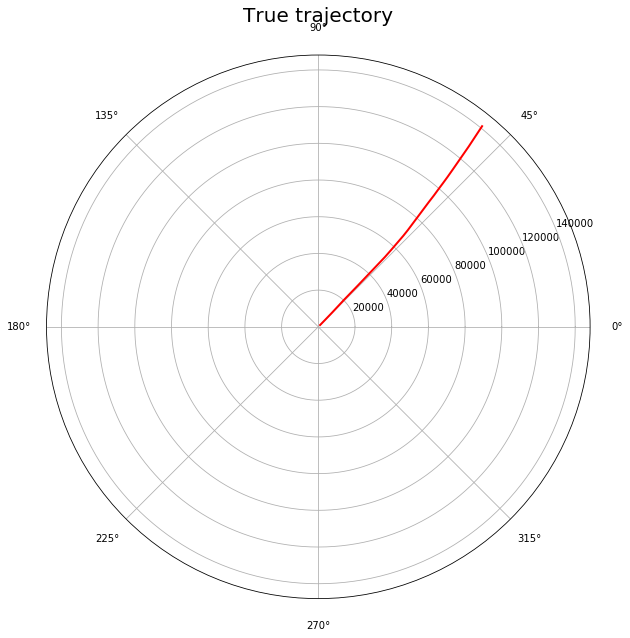

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('True trajectory', fontsize = 20)
ax.plot(b, D, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Generate measurements $D^m$ and $\beta^m$

In [32]:
sigma_D = 50
sigma_b = 0.004
z = [np.zeros(1) for x in range(N)]
for i in range(0, N, 2):
    D_n = np.random.normal(0, sigma_D, 1)
    b_n = np.random.normal(0, sigma_b, 1)
    z[i] = np.array([D_n + D[i],b_n + b[i]])

# Generate more accurate measurements of azimuth 

In [33]:
sigma_b_add = 0.001
for i in range(1, N, 2):
    b_n = np.random.normal(0, sigma_b_add, 1)
    z[i] = np.array([b_n + b[i]])

# Initial conditions for Kalman filter algorithm

In [37]:
x_1 = z[0][0, 0] * math.sin(z[0][1, 0])
x_3 = z[2][0, 0] * math.sin(z[2][1, 0])
y_1 = z[0][0, 0] * math.cos(z[0][1, 0])
y_3 = z[2][0, 0] * math.cos(z[2][1, 0])
X_0 = np.array([[x_3],[(x_3 - x_1) / 2 / t], [y_3],[(y_3 - y_1) / 2 / t]])
P_0 = np.eye(4) * 10 ** 4

# Develop Kalman filter algorithm to estimate state vector

In [40]:
def h_1(X):
    x = X[0]
    y = X[2]
    H = np.zeros((2, 1))
    H[0] = (x ** 2 + y ** 2) ** 0.5
    H[1] = np.arctan(x / y)
    return H

def dh_1(X):
    x = X[0, 0]
    y = X[2, 0]
    dH = np.zeros((2, 4))
    dH[0, 0] = x / (x ** 2 + y ** 2) ** 0.5
    dH[0, 2] = y / (x ** 2 + y ** 2) ** 0.5
    dH[1, 0] = y / (x ** 2 + y ** 2)
    dH[1, 2] = - x / (x ** 2 + y ** 2)
    return dH

def h_2(X):
    x = X[0]
    y = X[2]
    H = np.zeros((1, 1))
    H[0] = np.arctan(x / y)
    return H

def dh_2(X):
    x = X[0, 0]
    y = X[2, 0]
    dH = np.zeros((1, 4))
    dH[0, 0] = y / (x ** 2 + y ** 2)
    dH[0, 2] = - x / (x ** 2 + y ** 2)
    return dH

R_1 = np.array([[sigma_D ** 2, 0], [0, sigma_b ** 2]])
R_2 = np.array([[sigma_b_add ** 2]])

In [45]:
T = np.zeros((4, 4))
T[0:2, 0:2] = np.array([[1, t], [0, 1]])
T[2:4, 2:4] = np.array([[1, t], [0, 1]])

G = np.zeros((4, 2)) 
G[0:2, 0:1] = np.array([[t ** 2 / 2], [t]])
G[2:4, 1:2] = np.array([[t ** 2 / 2], [t]])
Q = G.dot(G.transpose() * sigma_a_2)


dh = list(range(N))
h = list(range(N))
R = list(range(N))
for i in range(0, N, 2):
    h[i] = h_1
    dh[i] = dh_1
    R[i] = R_1
    
for i in range(1, N, 2):
    h[i] = h_2
    dh[i] = dh_2
    R[i] = R_2

In [54]:
X, Xp = kalman(X_0, P_0, z, T, h, R, Q, dh, 3)

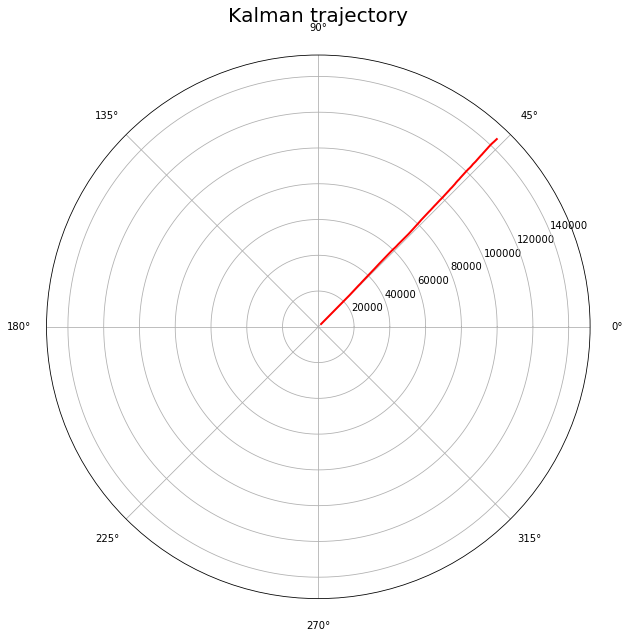

In [74]:
b_f, D_f = convert_to_polar(Xp)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('Kalman trajectory', fontsize = 20)
ax.plot(b_f, D_f, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Run Kalman filter algorithm over $M=500$ runs

In [67]:
M = 500
error_b_f = np.zeros((N, M))
error_D_f = np.zeros((N, M))
error_b_p = np.zeros((N, M))
error_D_p = np.zeros((N, M))

for i in range(M):
    x, _ = generate_acc_trajectory(sigma_a_2, 1, N, x_0, v_x, t)
    y, _ = generate_acc_trajectory(sigma_a_2, 1, N, y_0, v_y, t)
    
    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    z = [np.zeros(1) for x in range(N)]
    for j in range(0, N, 2):
        D_n = np.random.normal(0, sigma_D, 1)
        b_n = np.random.normal(0, sigma_b, 1)
        z[j] = np.array([D_n + D[j],b_n + b[j]])
    for j in range(1, N, 2):
        b_n = np.random.normal(0, sigma_b_add, 1)
        z[j] = np.array([b_n + b[j]])
        
    x_1 = z[0][0, 0] * math.sin(z[0][1, 0])
    x_3 = z[2][0, 0] * math.sin(z[2][1, 0])
    y_1 = z[0][0, 0] * math.cos(z[0][1, 0])
    y_3 = z[2][0, 0] * math.cos(z[2][1, 0])
    X_0 = np.array([[x_3],[(x_3 - x_1) / 2 / t], [y_3],[(y_3 - y_1) / 2 / t]])
    
    X, Xp = kalman(X_0, P_0, z, T, h, R, Q, dh, 3)
    
    b_f, D_f = convert_to_polar(X)
    b_p, D_p = convert_to_polar(Xp)
    
    error_b_f[:,i] = (b - b_f) ** 2
    error_D_f[:,i] = (D - D_f) ** 2
    error_b_p[:,i] = (b - b_p) ** 2
    error_D_p[:,i] = (D - D_p) ** 2

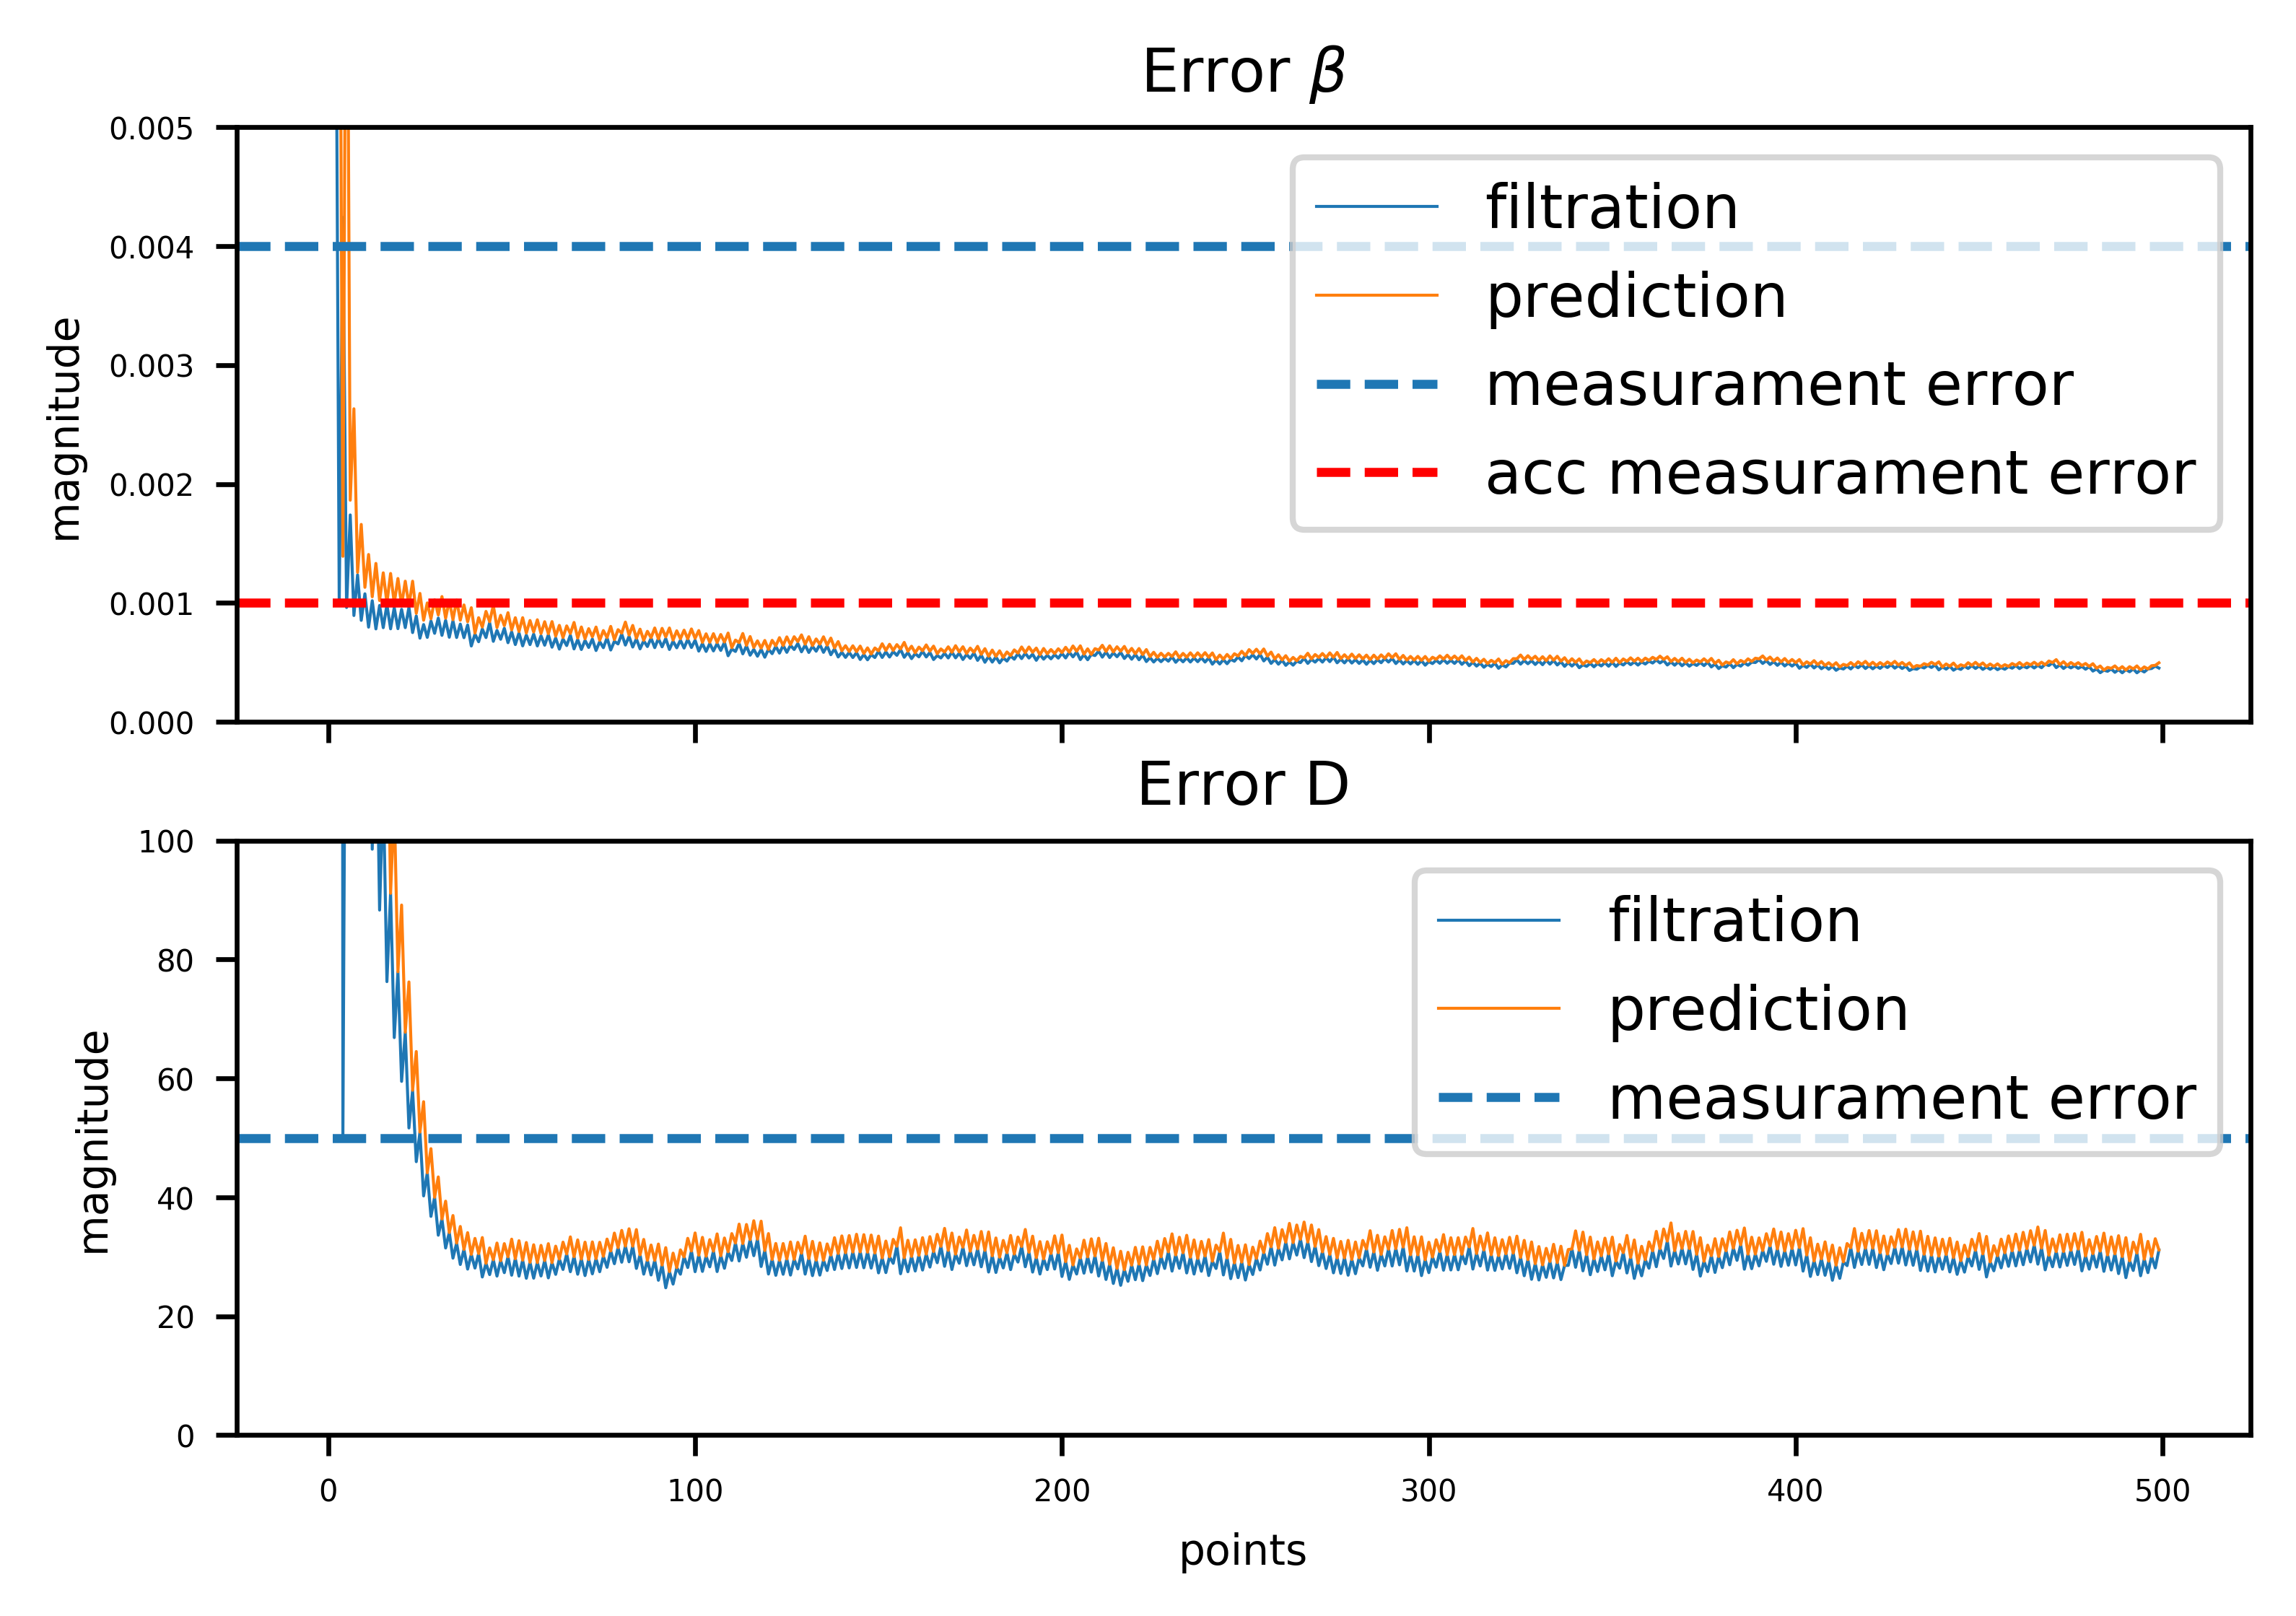

In [73]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600, sharex = True)
ax[0].set_title(r'Error $\beta$', fontsize = 10)
ax[0].plot( (np.sum(error_b_f,axis=1)/(M-1))**0.5, label = 'filtration', linewidth=0.5)
ax[0].plot( (np.sum(error_b_p,axis=1)/(M-1))**0.5,  label = 'prediction', linewidth=0.5)
ax[0].set_ylabel('magnitude', fontsize = 7)
ax[0].axhline(sigma_b, label = "measurament error", linestyle='--')
ax[0].axhline(sigma_b_add, label = "acc measurament error", color = 'r', linestyle='--')
ax[0].set_ylim((0, 0.005))
ax[0].legend(loc='upper right')

ax[1].set_title('Error D', fontsize = 10)
ax[1].plot( (np.sum(error_D_f,axis=1)/(M-1))**0.5, label = 'filtration', linewidth=0.5)
ax[1].plot( (np.sum(error_D_p,axis=1)/(M-1))**0.5,  label = 'prediction', linewidth=0.5)
ax[1].set_xlabel('points', fontsize = 7)
ax[1].set_ylabel('magnitude', fontsize = 7)
ax[1].axhline(sigma_D, label = "measurament error", linestyle='--')
ax[1].set_ylim((0, 100))
ax[1].legend(loc='upper right');

## One can see from this plot that measurement error (even more accurate measurement error) is times higher than true estimaiton error of filtration and prediction. Also there is an oscillation of Error D and Error b which corespond to different measurements. It can be due-to different accuracy of measurements on odd and even steps.

# Conclusion

## Today we have learned extended Kalman filter with different sources of measurements